<a href="https://colab.research.google.com/github/mockingjay14/ml_scripts/blob/main/examples/ex1_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experiment 1: Using Pytorch

## Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

## Load Data & Transform Data

In [2]:
# Download Training Data
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download Test Data
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [3]:
# Create Dataloaders

# Input Parameter
batch_size = 64

# Instantiate Dataloader
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

In [4]:
# Create Label Map

labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

## Split Data

## Check Data

In [5]:
# Check Train Dataloader Size
for X, y in test_dataloader:
  print("Train Dataloader:")
  print(f"Shape of X [N, C, H, W]: {X.shape}")
  print(f"Shape of y: {y.shape} {y.dtype}")
  break

print('====================================================')

# Check Test Dataloader Size
for X, y in test_dataloader:
  print("Test Dataloader:")
  print(f"Shape of X [N, C, H, W]: {X.shape}")
  print(f"Shape of y: {y.shape} {y.dtype}")
  break

Train Dataloader:
Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64
Test Dataloader:
Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


In [6]:
# Helper Functions

# Function for Displaying Batch Data
def display_batch_data(batch_data, size):
  rows, cols = size
  figure = plt.figure(figsize=(8, 8))
  for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(batch_data), size=(1,)).item()
    img, label = batch_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
  plt.show()

# Function for Displaying Single Data
def get_single_data(batch_data, index):
  X, y = batch_data[index]
  output = X.squeeze().cpu().numpy()
  return output, y

Training Data:


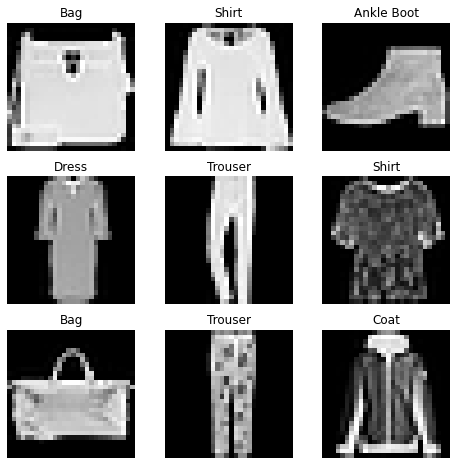

Test Data:


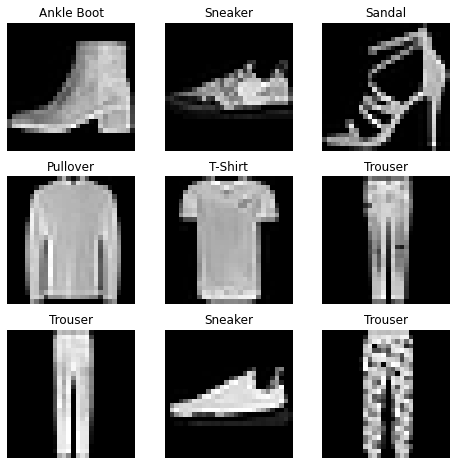

In [7]:
# Display Data

# Training Data
print("Training Data:")
display_batch_data(training_data, size=(3,3))

print('===========================================================')

# Test Data
print("Test Data:")
display_batch_data(test_data, size=(3,3))

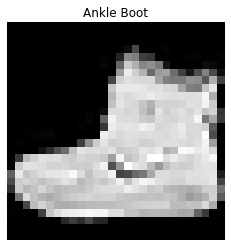

In [8]:
# Display Single Image

value, label = get_single_data(training_data, index=0)
plt.title(labels_map[label])
plt.imshow(value, cmap=plt.get_cmap("gray"))
plt.axis("off")
plt.show()

## Create Model

In [9]:
# Define Device for Training

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [10]:
# Define Residual Block

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False):
        super(ResidualBlock,self).__init__()
        self.cnn1 =nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        self.cnn2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size, 1, padding, bias=False),
            nn.BatchNorm2d(out_channels)
        )
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.shortcut = nn.Sequential()
            
    def forward(self,x):
        residual = x
        x = self.cnn1(x)
        x = self.cnn2(x)
        x += self.shortcut(residual)
        x = nn.ReLU(inplace=True)(x)
        return x

In [11]:
# Define ResNet34 Model

class ResNet34(nn.Module):
    def __init__(self, input_channels, output_dim):
        super(ResNet34,self).__init__()
        
        self.block1 = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=7, stride=2, 
                      padding=3, bias=False),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(inplace=True)
        )
        
        self.block2 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            ResidualBlock(in_channels=64, out_channels=64),
            ResidualBlock(in_channels=64, out_channels=64, stride=2)
        )
        
        self.block3 = nn.Sequential(
            ResidualBlock(in_channels=64, out_channels=128),
            ResidualBlock(in_channels=128, out_channels=128,stride=2)
        )
        
        self.block4 = nn.Sequential(
            ResidualBlock(in_channels=128, out_channels=256),
            ResidualBlock(in_channels=256, out_channels=256, stride=2)
        )
        self.block5 = nn.Sequential(
            ResidualBlock(in_channels=256, out_channels=512),
            ResidualBlock(in_channels=512, out_channels=512, stride=2)
        )
        
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=1)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(512, output_dim)
        
    def forward(self,x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.avgpool(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

In [12]:
# Load Model to Device

model = ResNet34(input_channels=1, output_dim=10).to(device)
print(model)

ResNet34(
  (block1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (block2): Sequential(
    (0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (1): ResidualBlock(
      (cnn1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (cnn2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (shortcut): Sequential()
    )
    (2): ResidualBlock(
      (cnn1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(

## Train Model

In [13]:
# Define Loss Function and Optimizer

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [14]:
# Training and Test Functions

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [15]:
# Training Process

epochs = 20
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.484146  [    0/60000]
loss: 0.649597  [ 6400/60000]
loss: 0.350050  [12800/60000]
loss: 0.532266  [19200/60000]
loss: 0.697829  [25600/60000]
loss: 0.429436  [32000/60000]
loss: 0.376536  [38400/60000]
loss: 0.541290  [44800/60000]
loss: 0.334815  [51200/60000]
loss: 0.475697  [57600/60000]
Test Error: 
 Accuracy: 84.9%, Avg loss: 0.398475 

Epoch 2
-------------------------------
loss: 0.349657  [    0/60000]
loss: 0.284859  [ 6400/60000]
loss: 0.253648  [12800/60000]
loss: 0.358144  [19200/60000]
loss: 0.547422  [25600/60000]
loss: 0.396163  [32000/60000]
loss: 0.244761  [38400/60000]
loss: 0.418563  [44800/60000]
loss: 0.306817  [51200/60000]
loss: 0.311488  [57600/60000]
Test Error: 
 Accuracy: 85.2%, Avg loss: 0.414802 

Epoch 3
-------------------------------
loss: 0.318251  [    0/60000]
loss: 0.270347  [ 6400/60000]
loss: 0.235870  [12800/60000]
loss: 0.267347  [19200/60000]
loss: 0.320776  [25600/60000]
loss: 0.341820  [32000/600

## Save Model

In [16]:
# Save Pytorch Model

torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


## Load Model

In [18]:
# Load Pytorch Model

model = ResNet34(input_channels=1, output_dim=10)
model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

Predicted: "Ankle Boot", Actual: "Ankle Boot"


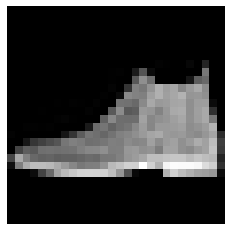

In [19]:
# Test Model for Predictions

model.eval()
x, y = test_data[0][0], test_data[0][1]

with torch.no_grad():
    pred = model(x.unsqueeze(0))
    predicted, actual = labels_map[pred[0].argmax(0).item()], labels_map[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

plt.figure()
plt.imshow(x.squeeze(), cmap=plt.get_cmap("gray"))
plt.axis("off")
plt.show()